# Vector DB 사용
- Vectore DB : pinecone, Cloud기반

In [1]:
!pip install -qU python-dotenv
!pip install -qU langchain langchain-community langchain-openai

!pip install -qU pinecone-client langchain-pinecone
!pip install -qU pandas matplotlib tqdm ipywidgets

# 환경변수 설정

In [3]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)


True

In [4]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

# pinecone 객체생성
- pinecone 클라이언트 초기화

In [ ]:
from pinecone import Pinecone, ServerlessSpec

# Pinecone 클라이언트 초기화
pc = Pinecone(api_key=PINECONE_API_KEY)


In [11]:
# 인덱스 객체생성
index = pc.Index("embedding-3d")


In [12]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

# 레코드 업서트(Upsert)

## 데이터 준비 및 embedding vector 만들기

In [16]:
    vectors=[
        {
            "id": "vec1",
            "values": [1.0, 1.5, 2.0],  # 임베딩 벡터, 행벡터 3차원
            "metadata": {"genre": "drama"}  # 
        }, {
            "id": "vec2",
            "values": [2.0, 1.0, 0.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec3",
            "values": [0.1, 0.3, 0.5],
            "metadata": {"genre": "drama"}
        }, {
            "id": "vec4",
            "values": [1.0, 2.5, 3.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec5",
            "values": [3.0, 1.2, 1.3],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec6",
            "values": [0.3, 1.1, 2.5],
            "metadata": {"genre": "drama"}
        }
    ]
vectors

[{'id': 'vec1', 'values': [1.0, 1.5, 2.0], 'metadata': {'genre': 'drama'}},
 {'id': 'vec2', 'values': [2.0, 1.0, 0.5], 'metadata': {'genre': 'action'}},
 {'id': 'vec3', 'values': [0.1, 0.3, 0.5], 'metadata': {'genre': 'drama'}},
 {'id': 'vec4', 'values': [1.0, 2.5, 3.5], 'metadata': {'genre': 'action'}},
 {'id': 'vec5', 'values': [3.0, 1.2, 1.3], 'metadata': {'genre': 'action'}},
 {'id': 'vec6', 'values': [0.3, 1.1, 2.5], 'metadata': {'genre': 'drama'}}]

# VectorDB에 저장

In [18]:
index.upsert(
    vectors=vectors,
    namespace="embedding-3d-ns1" # 검색속도를 높임
)

{'upserted_count': 6}

# 검색(쿼리)하기

In [21]:
# 유사도 높은 데이터 검색
response = index.query(
    namespace="embedding-3d-ns1",  # 네임 스페이스
    # namespace="",  # default, 기본 공간에서 찾음  , layer : 비슷한 것끼리 모아둠
    vector=[0.1, 0.3, 0.7],  # 쿼리 백터
    top_k=6,
    include_values=True,   # value 포함
    include_metadata=True  # 메터데이터 포함
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999722,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990118921,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec4',
              'metadata': {'genre': 'action'},
              'score': 0.972905517,
              'values': [1.0, 2.5, 3.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.942745209,
              'values': [1.0, 1.5, 2.0]},
             {'id': 'vec5',
              'metadata': {'genre': 'action'},
              'score': 0.586637914,
              'values': [3.0, 1.2, 1.3]},
             {'id': 'vec2',
              'metadata': {'genre': 'action'},
              'score': 0.48296234,
              'values': [2.0, 1.0, 0.5]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


In [23]:
## 조건 검색

In [22]:
# filter (dict): 쿼리할 벡터의 필터 조건.
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1, 0.3, 0.7],
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={   # where 절 같은것
        "genre": {"$eq": "drama"}
    }
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999722,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990118921,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.942745209,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


## 네임스페이스의 모든 레코드 ID 조회

In [25]:
for ids in index.list(namespace="embedding-3d-ns1"):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [26]:
print(index.list(namespace="embedding-3d-ns1"))

<generator object Index.list at 0x000001CDC42E22F0>


In [32]:
list(index.list(namespace="embedding-3d-ns1"))[0]

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']

In [37]:
## for문을 사용하지 않고, namespace의 저장 값 조회
vectors = index.fetch(ids=ids, namespace="embedding-3d-ns1").vectors
vectors

{'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.0, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None)}

In [40]:
print(vectors.values())

dict_values([Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec2', values=[2.0, 1.0, 0.5], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None)])


In [44]:
# ids: 벡터 데이터에서 추출한 ID 리스트.
# values: 벡터 데이터에서 추출한 값 리스트.
ids = [v['id'] for v in vectors.values()]
values = [v['values'] for v in vectors.values()]

ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec6', 'vec4', 'vec2', 'vec5', 'vec1', 'vec3', 'qv']
[[0.3, 1.1, 2.5], [1.0, 2.5, 3.5], [2.0, 1.0, 0.5], [3.0, 1.2, 1.3], [1.0, 1.5, 2.0], [0.1, 0.3, 0.5], [0.1, 0.3, 0.7]]


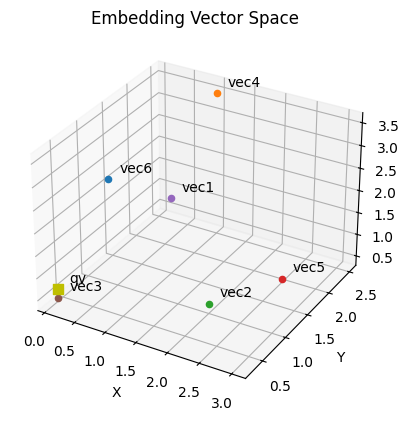

In [45]:
# embedding vector 시각화
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

## 서버리스 인덱스 삭제

In [47]:
# Pinecone에 있는 모든 인덱스를 순회합니다.
index_name = "embedding-3d"
for idx in pc.list_indexes():
    # 인덱스 이름이 "quickstart"와 일치하는 경우 해당 인덱스를 삭제합니다.
    if idx.name == index_name:
        pc.delete_index(idx.name)

## 인덱스 생성

In [49]:
index_name = "quickstart"
pc.create_index(
    name=index_name,
    dimension=1024,  # 모델 차원
    metric="cosine",  # 모델 메트릭
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-q0lrvkd.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

## 사용 가능한 인덱스 확인

In [50]:
pc.list_indexes()

[
    {
        "name": "quickstart",
        "metric": "cosine",
        "host": "quickstart-q0lrvkd.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "vector_type": "dense",
        "dimension": 1024,
        "deletion_protection": "disabled",
        "tags": null
    }
]

## 임베딩 벡터 생성

In [51]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

## 덱스트 데이터를 임베딩 벡터로 전환

In [ ]:

embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[d['text'] for d in data],
    parameters={"input_type": "passage", "truncate": "END"}
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embeddings[0])

{'vector_type': dense, 'values': [0.0301055908203125, -0.0205841064453125, ..., -0.0302276611328125, 0.0241241455078125]}


## 레코드 업세트(Upsert)

In [54]:
import time

# 인덱스가 준비될 때까지 대기합니다.
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

# 인덱스를 초기화합니다.
index = pc.Index(index_name)

# 벡터 리스트를 초기화합니다. / 벡터DB에 넣을 데이터셋 구성
vectors = []
for d, e in zip(data, embeddings):
    # 각 데이터와 임베딩을 결합하여 벡터를 생성합니다.
    vectors.append({
        "id": d['id'],
        "values": e['values'],
        "metadata": {'text': d['text']}
    })

# 벡터를 인덱스에 업서트(upsert)합니다. 
# quickstart_ns1 네임스페이스에 벡터를 추가합니다.
index.upsert(
    vectors=vectors,
    namespace="quickstart_ns1"
)

{'upserted_count': 6}

## 인덱스 통계 정보 확인

In [55]:
# Pinecone 인덱스의 통계 정보를 설명하는 메서드를 호출하고, 그 결과를 출력합니다.
# 인덱스의 통계 정보에는 인덱스에 저장된 벡터의 수, 차원, 메타데이터 등의 정보가 포함될 수 있습니다.
# print(index.describe_index_stats())
print(index.describe_index_stats(namespace="quickstart_ns1"))

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart_ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}


In [56]:
# 쿼리 텍스트를 정의합니다.
query = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  # ms 오픈 소스, 1024 차원
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}


In [58]:
# ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터를 검색합니다.
# 검색 결과에는 벡터 값은 포함되지 않고 메타데이터만 포함됩니다.
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=True,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.896352232,
              'values': [0.0219573975,
                         -0.0276794434,
                         -0.0180664062,
                         -0.0275726318,
                         0.0418396,
                         -0.0291442871,
                         -0.0318908691,
                         0.0628051758,
                         0.0394592285,
                         -0.0405578613,
                         0.0280609131,
                         0.00303840637,
                         -0.033782959,
                         0.00778961182,
                         -0.00667190552,
                         -0.017578125,
                         -0.0556640625,
                         0.00201797485,
                         0.00693511963,
                         -0.0205383301,
                         0.0228424072,
                         -0.0

In [61]:
# 쿼리 텍스트를 정의합니다.
query = "애플(사과)라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [-0.00445556640625, -0.021484375, ..., -0.0186614990234375, 0.0077972412109375]}
